https://www.kaggle.com/williamroe/bi-lstm-with-crf-for-ner

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
print(keras.__version__)
from math import nan
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


2.2.4


In [3]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF

from subprocess import check_output
print(check_output(["ls", "/Users/patsnap/Desktop/Neo4J_and_other_codes/Topic_modelling/annotated_corpus"]).decode("utf8"))

  Cloning https://www.github.com/keras-team/keras-contrib.git to /private/var/folders/07/ch803bln2x51cptcxk5bs3gr0000gn/T/pip-req-build-yth15oiz
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /private/var/folders/07/ch803bln2x51cptcxk5bs3gr0000gn/T/pip-req-build-yth15oiz
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101065 sha256=3e55fde8652653329819c53eda2a930ddcb4e6e35980cc5f23b9c275bd55543f
  Stored in directory: /private/var/folders/07/ch803bln2x51cptcxk5bs3gr0000gn/T/pip-ephem-wheel-cache-pza1j2w5/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib
ner.csv
ner_dataset.csv



In [4]:
dframe = pd.read_csv("/Users/patsnap/Desktop/Neo4J_and_other_codes/Topic_modelling/annotated_corpus/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [5]:
dframe

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050790,1048570,they,respond,to,TO,lowercase,to,VBD,lowercase,responded,...,forc,NNS,lowercase,forces,lowercase,said,47959.0,lowercase,they,O
1050791,1048571,respond,to,the,DT,lowercase,the,TO,lowercase,to,...,said,VBD,lowercase,said,lowercase,they,47959.0,lowercase,responded,O
1050792,1048572,to,the,attack,NN,lowercase,attack,DT,lowercase,the,...,they,PRP,lowercase,they,lowercase,responded,47959.0,lowercase,to,O
1050793,1048573,the,attack,with,IN,lowercase,with,NN,lowercase,attack,...,respond,VBD,lowercase,responded,lowercase,to,47959.0,lowercase,the,O


In [6]:
dframe.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

In [7]:
dataset=dframe.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word',"pos"],axis=1)

In [8]:
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 4 columns):
sentence_idx    1050794 non-null float64
shape           1050794 non-null object
word            1050794 non-null object
tag             1050794 non-null object
dtypes: float64(1), object(3)
memory usage: 32.1+ MB


,sentence_idx,shape,word,tag
0,1.0,capitalized,Thousands,O
1,1.0,lowercase,of,O
2,1.0,lowercase,demonstrators,O
3,1.0,lowercase,have,O
4,1.0,lowercase,marched,O


In [9]:
dataset=dataset.drop(['shape'],axis=1)
dataset.head()

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O


In [10]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(dataset)
sentences = getter.sentences
print(sentences[5])

[('The', 'O'), ('party', 'O'), ('is', 'O'), ('divided', 'O'), ('over', 'O'), ('Britain', 'B-gpe'), ("'s", 'O'), ('participation', 'O'), ('in', 'O'), ('the', 'O'), ('Iraq', 'B-geo'), ('conflict', 'O'), ('and', 'O'), ('the', 'O'), ('continued', 'O'), ('deployment', 'O'), ('of', 'O'), ('8,500', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('in', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O'), ('The', 'O'), ('party', 'O'), ('is', 'O'), ('divided', 'O'), ('over', 'O'), ('Britain', 'B-gpe'), ("'s", 'O'), ('participation', 'O'), ('in', 'O'), ('the', 'O'), ('Iraq', 'B-geo'), ('conflict', 'O'), ('and', 'O'), ('the', 'O'), ('continued', 'O'), ('deployment', 'O'), ('of', 'O'), ('8,500', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('in', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [12]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


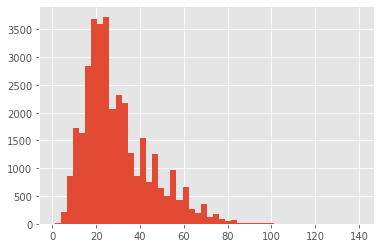

In [13]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [14]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

30174

In [15]:
tags = []
for tag in set(dataset["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
print(tags)
n_tags = len(tags); n_tags

['I-tim', 'B-eve', 'unk', 'O', 'B-per', 'B-art', 'B-geo', 'I-eve', 'I-per', 'I-nat', 'B-tim', 'B-gpe', 'B-org', 'I-org', 'I-art', 'B-nat', 'I-gpe', 'I-geo']


18

In [16]:
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [17]:
word2idx['Obama']

4499

In [18]:
tag2idx

{'I-tim': 0,
 'B-eve': 1,
 'unk': 2,
 'O': 3,
 'B-per': 4,
 'B-art': 5,
 'B-geo': 6,
 'I-eve': 7,
 'I-per': 8,
 'I-nat': 9,
 'B-tim': 10,
 'B-gpe': 11,
 'B-org': 12,
 'I-org': 13,
 'I-art': 14,
 'B-nat': 15,
 'I-gpe': 16,
 'I-geo': 17}

In [19]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [20]:
X = pad_sequences(maxlen=140, sequences=X, padding="post",value=n_words - 1)

In [21]:
y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
print(sentences[100])
print(y_idx[100])

[('The', 'O'), ('Pakistani', 'B-gpe'), ('military', 'O'), ('launched', 'O'), ('its', 'O'), ('offensive', 'O'), ('in', 'O'), ('Orakzai', 'B-geo'), ('to', 'O'), ('hunt', 'O'), ('Taliban', 'B-org'), ('insurgents', 'O'), ('.', 'O'), ('The', 'O'), ('Pakistani', 'B-gpe'), ('military', 'O'), ('launched', 'O'), ('its', 'O'), ('offensive', 'O'), ('in', 'O'), ('Orakzai', 'B-geo'), ('to', 'O'), ('hunt', 'O'), ('Taliban', 'B-org'), ('insurgents', 'O'), ('.', 'O')]
[3, 11, 3, 3, 3, 3, 3, 6, 3, 3, 12, 3, 3, 3, 11, 3, 3, 3, 3, 3, 6, 3, 3, 12, 3, 3]


In [22]:
y = pad_sequences(maxlen=140, sequences=y_idx, padding="post", value=tag2idx["O"])
print(y_idx[100])

[3, 11, 3, 3, 3, 3, 3, 6, 3, 3, 12, 3, 3, 3, 11, 3, 3, 3, 3, 3, 6, 3, 3, 12, 3, 3]


In [23]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k

In [26]:
input = Input(shape=(140,))
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=140)(input)
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # previously softmax output layer

crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
model = Model(input, out)

In [28]:
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
#model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/Users/patsnap/anaconda2/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/patsnap/anaconda2/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 140, 300)          9052200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 600)          1442400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 140, 600)          2882400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 140, 18)           10818     
_________________________________________________________________
crf_1 (CRF)                  (None, 140, 18)           702       
Total params: 13,388,520
Trainable params: 13,388,520
Non-trainable params: 0
________________________________________________________________

# Save the model after each epoch if validation is better

In [29]:
# Saving the best only
filepath="ner-bi-lstm-td-model-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [30]:
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=1, validation_split=0.2, verbose=1, callbacks=callbacks_list)




Train on 22512 samples, validate on 5629 samples
Epoch 1/1





22512/22512 [==============================] - 1231s 55ms/step - loss: 0.3298 - crf_viterbi_accuracy: 0.9375 - acc: 0.0013 - val_loss: 0.1670 - val_crf_viterbi_accuracy: 0.9677 - val_acc: 0.9677

Epoch 00001: val_acc improved from -inf to 0.96773, saving model to ner-bi-lstm-td-model-0.97.hdf5


In [31]:
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1

In [32]:
i = 357
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
gt = np.argmax(y_test[i], axis=-1)
print(gt)
print("{:14}: ({:5}): {}".format("Word", "True", "Pred"))
for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
    #
    print("{:14}: ({:5}): {}".format(words[w],idx2tag[gt[idx]],tags[pred]))

[ 3  3  3  3  3  3 10  0  3  3  3  3  3 10  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3]
Word          : (True ): Pred
The           : (O    ): O
officials     : (O    ): O
,             : (O    ): O
including     : (O    ): O
Energy        : (O    ): O
Minister      : (O    ): O
July          : (B-tim): O
Moyo          : (I-tim): O
,             : (O    ): O
were          : (O    ): O
initially     : (O    ): O
suspended     : (O    ): O
for           : (O    ): O
six           : (B-tim): O
months        : (O    ): O
.             : (O    ): O
ENDPAD        : (O    ): O
ENDPAD        : (O    ): O
ENDPAD        : (O    ): O
ENDPAD        : (O    ): O
END

In [33]:
p = model.predict(np.array(X_test))  

In [34]:
from sklearn.metrics import classification_report

In [35]:
np.argmax(p, axis=2)[0]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

In [36]:
print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))

/Users/patsnap/anaconda2/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
/Users/patsnap/anaconda2/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.


              precision    recall  f1-score   support

       I-tim       0.00      0.00      0.00      1259
       B-eve       0.00      0.00      0.00        61
         unk       0.00      0.00      0.00         0
           O       0.97      1.00      0.98    952440
       B-per       0.00      0.00      0.00      3401
       B-art       0.00      0.00      0.00        96
       B-geo       0.00      0.00      0.00      7618
       I-eve       0.00      0.00      0.00        46
       I-per       0.00      0.00      0.00      3539
       I-nat       0.00      0.00      0.00        19
       B-tim       0.00      0.00      0.00      4056
       B-gpe       0.00      0.00      0.00      3321
       B-org       0.00      0.00      0.00      4110
       I-org       0.00      0.00      0.00      3374
       I-art       0.00      0.00      0.00        70
       B-nat       0.00      0.00      0.00        62
       I-gpe       0.00      0.00      0.00        40
       I-geo       0.00    

In [37]:
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(p[i], axis=-1)
    gt = np.argmax(y_test[i], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])

In [38]:
for tag in tag2idx.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))   

tag:I-tim
	 TN:         0	FP:         0
	 FN:      1259	TP:         0
tag:B-eve
	 TN:         0	FP:         0
	 FN:        61	TP:         0
tag:unk
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:O
	 TN:         0	FP:         0
	 FN:         0	TP:    952440
tag:B-per
	 TN:         0	FP:         0
	 FN:      3401	TP:         0
tag:B-art
	 TN:         0	FP:         0
	 FN:        96	TP:         0
tag:B-geo
	 TN:         0	FP:         0
	 FN:      7618	TP:         0
tag:I-eve
	 TN:         0	FP:         0
	 FN:        46	TP:         0
tag:I-per
	 TN:         0	FP:         0
	 FN:      3539	TP:         0
tag:I-nat
	 TN:         0	FP:         0
	 FN:        19	TP:         0
tag:B-tim
	 TN:         0	FP:         0
	 FN:      4056	TP:         0
tag:B-gpe
	 TN:         0	FP:         0
	 FN:      3321	TP:         0
tag:B-org
	 TN:         0	FP:         0
	 FN:      4110	TP:         0
tag:I-org
	 TN:         0	FP:         0
	 FN:      3374	TP:         0
tag:I-art
	 TN:         0	